In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 

In [2]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
Pressure = [100, 75, 65, 55, 40, 30] # hPa
Height   = [16,  18, 19, 20, 22, 24] # km

In [4]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4+2

# Nx = 36
# Ny = 21
# Nz = 5
# N_parcel = 3780

Nx = 24
Ny = 21
Nz = 6
N_parcel = Nx*Ny*Nz

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    

directory = './Lifetime/'
filename = "Lifetime_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory+filename)

/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_2000/Lifetime_20000101.txt


In [5]:
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)

lifetime   = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_N = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_S = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lon = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lat = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lev = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

lifetime.shape

(5, 21, 36, 10, 12, 3)

In [6]:
for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            directory = './Lifetime/'
            filename = "Lifetime_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File = open(directory+filename, 'r')
        
            Lines = File.readlines()

            # Strips the newline character
            data = []
            data_N = []
            data_S = []
            data_x = []
            data_y = []
            data_z = []
            for line in Lines:
                a = line.split(',')
                data.append(float(a[0])) # total lifetime
                data_N.append(float(a[1])) # total N lifetime
                data_S.append(float(a[2])) # total S lifetime
                data_x.append(float(a[3])) # lon
                data_y.append(float(a[4])) # lat
                data_z.append(float(a[5])) # p
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        lifetime[iz,iy,ix,i_day,i_month,i_year] = data[i]
                        lifetime_N[iz,iy,ix,i_day,i_month,i_year] = data_N[i]
                        lifetime_S[iz,iy,ix,i_day,i_month,i_year] = data_S[i]
                        Lon[iz,iy,ix,i_day,i_month,i_year] = data_x[i]
                        Lat[iz,iy,ix,i_day,i_month,i_year] = data_y[i]
                        Lev[iz,iy,ix,i_day,i_month,i_year] = data_z[i]

                        i = i+1
                        
                        

100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


In [7]:
# month-mean

# lifetime(Nz, Ny, Nx, N_day, N_month, N_year)

lifetime_mon = np.mean(lifetime, axis=(3,5))
lifetime_N_mon = np.mean(lifetime_N, axis=(3,5))
lifetime_S_mon = np.mean(lifetime_S, axis=(3,5))

lifetime_mon.shape

(5, 21, 36, 12)

In [8]:
# regrid (lon,lat) from (10,2) to (30,6)
# combin 3x3 to 1 grid

Nx3 = int(Nx/3)
Ny3 = int(Ny/3)

lifetime_mon_9   = np.zeros((Nz, Ny3, Nx3, N_month))
lifetime_N_mon_9 = np.zeros((Nz, Ny3, Nx3, N_month))
lifetime_S_mon_9 = np.zeros((Nz, Ny3, Nx3, N_month))


for ix in range(Nx3):
    for iy in range(Ny3):
        lifetime_mon_9[:,iy,ix,:]   = np.mean(  lifetime_mon[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        lifetime_N_mon_9[:,iy,ix,:] = np.mean(lifetime_N_mon[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        lifetime_S_mon_9[:,iy,ix,:] = np.mean(lifetime_S_mon[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        
Lon2d_3 = Lon[0,1:Ny:3,1:Nx:3,0,0,0]
Lat2d_3 = Lat[0,1:Ny:3,1:Nx:3,0,0,0]
Lev2d_3 = Lev[0,1:Ny:3,1:Nx:3,0,0,0]

lifetime_mon_9.shape, Lon2d_3.shape

((5, 7, 12, 12), (7, 12))

In [9]:
print(Ny*Nx*N_day*N_month*N_year)

272160


In [10]:
# first test: one time injection
#
# Lon2d = Lon[0,:,:,0,0,0]
# Lat2d = Lat[0,:,:,0,0,0]
# Lev2d = Lev[0,:,:,0,0,0]

# Lon1d = Lon2d
# Lat1d = Lat2d
# Lev1d = Lev2d


#


In [11]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
# (Nz, Ny, Nx, N_month)

Result_mon = lifetime_mon_9[0,:,:,:]*0.0
iz = 1

# for LP solve: max lifetime under the interhemispheric balance
for imon in range(N_month):
    Life   = lifetime_mon_9[iz,:,:,imon].flatten()
    Life_S = lifetime_N_mon_9[iz,:,:,imon].flatten()
    Life_N = lifetime_S_mon_9[iz,:,:,imon].flatten()

    if sum(Life_S)+sum(Life_N)-sum(Life)>0.01: print("ERROR!!!")
    
    N = len(Life)


    #
    c = -1*Life

    Xs_bounds = []
    A1 = []
    A3 = []
    A4 = []
    A  = []
    for i in range(N):
        Xs_bounds.append((0, N))
        A1.append(1)
        A3.append( Life_N[i] -Life_S[i] -0.05*Life[i] )
        A4.append( -1*(Life_N[i] -Life_S[i] +0.05*Life[i]) )

    Aub = [A3,A4]
    Aeq = [A1]   

    b_ub = [0,0]
    b_eq = [N]

    from scipy.optimize import linprog
    res = linprog(c, A_eq=Aeq, b_eq=b_eq, A_ub=Aub, b_ub=b_ub, bounds=Xs_bounds)
    
    # post-process, calculate the injection percentage
    Result1d = np.round(res.x)
    Result2d = Result1d.reshape(Ny3,Nx3)
    Result2d = Result2d/np.sum(Result2d)*100
    
    Result_mon[:,:,imon] = Result2d
    

Lifetime_LP = lifetime_mon_9[iz,:,:,:]* (Result_mon/100)

Lifetime_LP_N = lifetime_N_mon_9[iz,:,:,:]* (Result_mon/100)
Lifetime_LP_S = lifetime_S_mon_9[iz,:,:,:]* (Result_mon/100)
D_lifetime_LP = Lifetime_LP_N - Lifetime_LP_S


print(lifetime_mon_9[iz,:,:,:].shape, Result_mon.shape)



# get the max lifetime

Inject_percent = np.zeros((Nz, Ny3, Nx3, N_month))
print(Inject_percent.shape)

for i_mon in range(N_month):
    a   = lifetime_mon_9[iz,:,:,i_mon]
    idx = np.unravel_index(np.argmax(a, axis=None), a.shape)
    print(iz,idx[0],idx[1],i_mon)
    Inject_percent[iz,idx[0],idx[1],i_mon] = 100


Lifetime_max = lifetime_mon_9[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)

Lifetime_max_N = lifetime_N_mon_9[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)
Lifetime_max_S = lifetime_S_mon_9[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)
D_lifetime_max = Lifetime_max_N - Lifetime_max_S

(7, 12, 12) (7, 12, 12)
(5, 7, 12, 12)
1 2 8 0
1 4 9 1
1 5 8 2
1 4 3 3
1 3 9 4
1 6 11 5
1 3 6 6
1 2 7 7
1 2 11 8
1 2 9 9
1 1 8 10
1 1 8 11


In [12]:
D_lifetime_max.shape

(7, 12, 12)

In [97]:
# find the (ix, iy) for the LP injection and Max injection

# iy_max, ix_max = np.where(Lifetime_max[:,:,imon] == np.max(Lifetime_max[:,:,imon]))
# print(iy_max[0], ix_max[0])

# Lifetime_max[iy_max,ix_max,imon], lifetime_mon_9[iz,iy_max,ix_max,imon]

In [98]:
# iy_LP, ix_LP = np.where(Lifetime_LP[:,:,imon] > 0)
# print(iy_LP, ix_LP)

# Lifetime_LP2[iy_LP,ix_LP,imon], lifetime_mon_9[iz,iy_LP,ix_LP,imon]

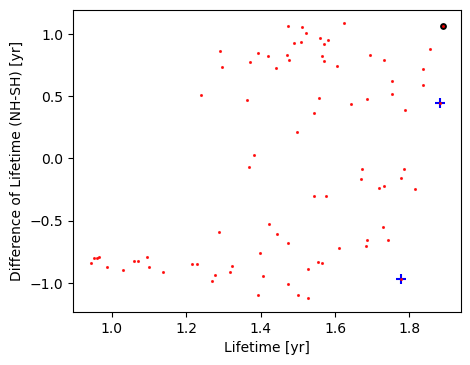

In [104]:
imon = 2

# find the location
iy_max, ix_max = np.where(Lifetime_max[:,:,imon] == np.max(Lifetime_max[:,:,imon]))
iy_LP, ix_LP = np.where(Lifetime_LP[:,:,imon] > 0)

# plot
D_life = lifetime_N_mon_9 - lifetime_S_mon_9

figure = plt.figure(figsize=(5,4), dpi=100)

plt.scatter(lifetime_mon_9[iz,iy_max,ix_max,imon]/365, D_life[iz,iy_max,ix_max,imon]/365, marker='o', color='black', s=15, alpha=1)
plt.scatter(lifetime_mon_9[iz,iy_LP,ix_LP,imon]/365, D_life[iz,iy_LP,ix_LP,imon]/365, marker='+', color='blue', s=60, alpha=1)

plt.scatter(lifetime_mon_9[iz,:,:,imon]/365, D_life[iz,:,:,imon]/365, marker='.', color='red', s=6, alpha=0.8)

plt.xlabel("Lifetime [yr]")
plt.ylabel("Difference of Lifetime (NH-SH) [yr]");

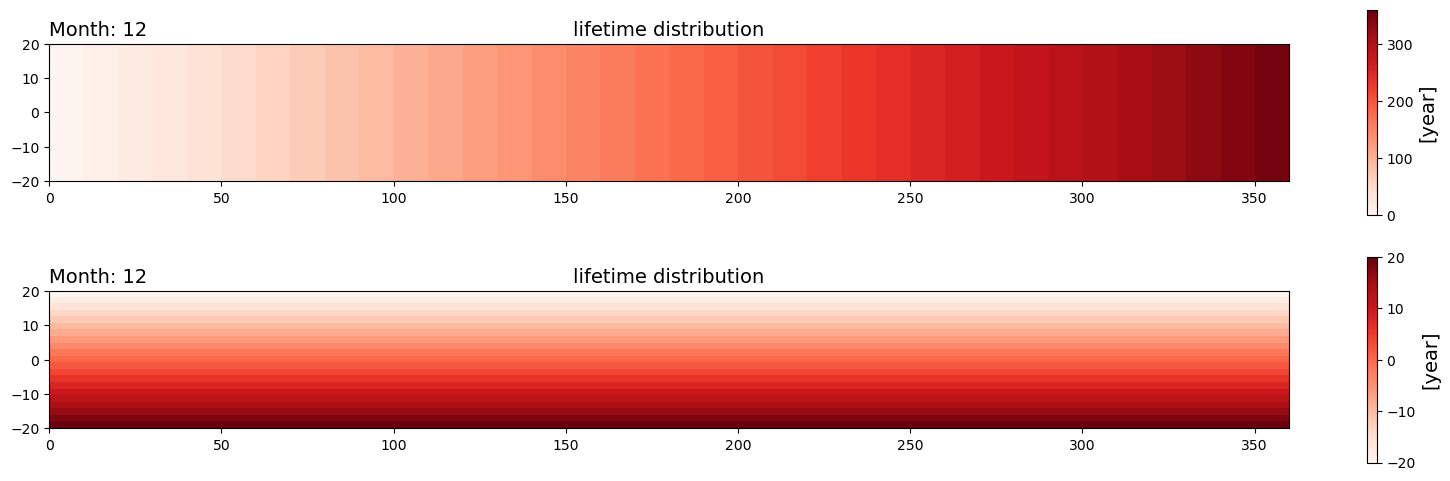

In [13]:
# check lon, lat are correct!!!

fig = plt.figure(figsize=(20,6), dpi=100)
extent = [0 , 360 , -20 , 20]

# Lon[iz,iy,ix,i_day,i_month,i_year]
# lifetime
ax0 = plt.subplot(2, 1, 1)

ax0_pixel = plt.imshow(Lon[0,:,:,0,0,0], vmin=0, vmax=360,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb0 = plt.colorbar(ax0_pixel, ax=ax0)
cb0.set_label('[year]', fontsize=14);

ax0.set_title(f"lifetime distribution", fontsize=14);
ax0.set_title(f"Month: {i_mon+1}", fontsize=14, loc="left");


###
ax1 = plt.subplot(2, 1, 2)

ax1_pixel = plt.imshow(Lat[0,:,:,0,0,0], vmin=-20, vmax=20,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[year]', fontsize=14);

ax1.set_title(f"lifetime distribution", fontsize=14);
ax1.set_title(f"Month: {i_mon+1}", fontsize=14, loc="left");

## Important for ploting: lat should be reversed!!!



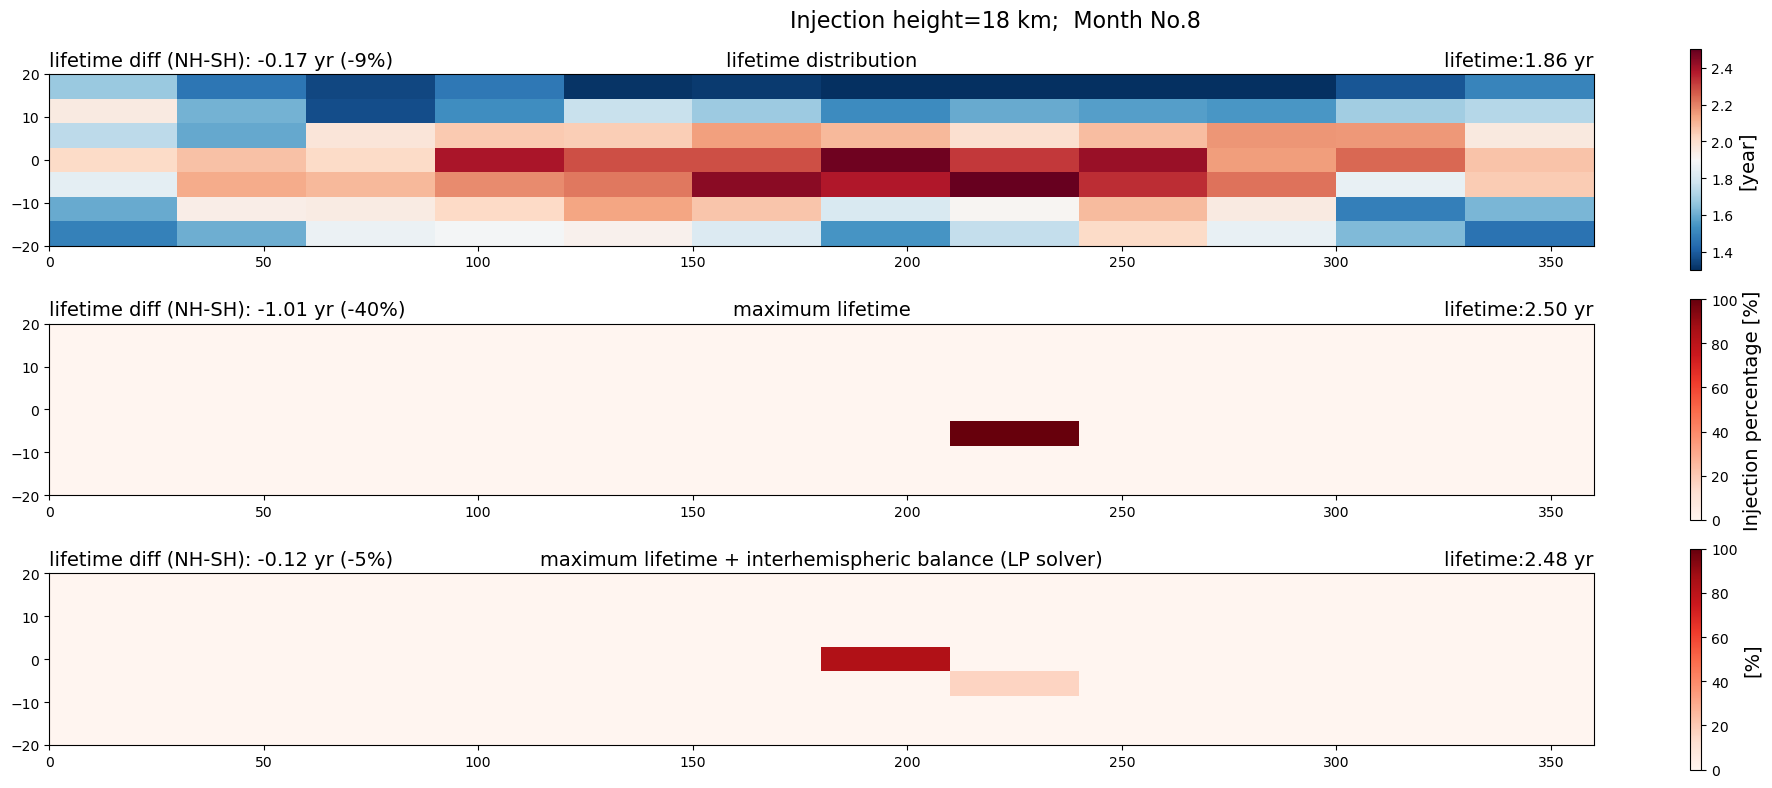

In [24]:
# select one month as a example

i_mon = 7

Life_LP = np.sum(Lifetime_LP[:,:,i_mon]/365.25, axis=(0,1))
Life_max = np.sum(Lifetime_max[:,:,i_mon]/365.25, axis=(0,1))


D_Life_LP = np.sum(D_lifetime_LP[:,:,i_mon]/365.25, axis=(0,1))
D_Life_max = np.sum(D_lifetime_max[:,:,i_mon]/365.25, axis=(0,1))


fig = plt.figure(figsize=(20,8), dpi=100)
plt.suptitle(f"Injection height={Height[iz]:.0f} km;  Month No.{i_mon+1}", fontsize=16);

extent = [0 , 360 , -20 , 20]

# Lon[iz,iy,ix,i_day,i_month,i_year]

#-----------------------------------------------------
# lifetime
ax0 = plt.subplot(3, 1, 1)

ax0_pixel = plt.imshow(lifetime_mon_9[iz,::-1,:,i_mon]/365, vmin=1.3, vmax=2.5,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb0 = plt.colorbar(ax0_pixel, ax=ax0)
cb0.set_label('[year]', fontsize=14);

Life_uniform = np.mean(lifetime_mon_9[iz,::-1,:,i_mon],axis=(0,1))/365

ax0.set_title(f"lifetime distribution", fontsize=14);
ax0.set_title(f"lifetime:{Life_uniform:.2f} yr", 
              fontsize=14, loc="right");

D_Life_uniform = np.mean(lifetime_N_mon_9[iz,:,:,i_mon]-lifetime_S_mon_9[iz,:,:,i_mon], axis=(0,1))/365

ax0.set_title(f"lifetime diff (NH-SH): {D_life_uniform:.2f} yr ({100*D_Life_uniform/Life_uniform:.0f}%)", 
              fontsize=14, loc="left");

#----------------------------------------------------
# maximum lifetime
ax1 = plt.subplot(3, 1, 2)
ax1_pixel = plt.imshow(Inject_percent[iz,::-1,:,i_mon], vmin=0, vmax=100,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('Injection percentage [%]', fontsize=14);

ax1.set_title(f"maximum lifetime", fontsize=14);
ax1.set_title(f"lifetime:{Life_max:.2f} yr", fontsize=14, loc="right");
ax1.set_title(f"lifetime diff (NH-SH): {D_Life_max:.2f} yr ({100*D_Life_max/Life_max:.0f}%)", 
              fontsize=14, loc="left");


#-----------------------------------------------------
# maximum lifetime and ensrue interhemispheric balance
ax2 = plt.subplot(3, 1, 3)
ax2_pixel = plt.imshow(Result_mon[::-1,:,i_mon], vmin=0, vmax=100,\
           extent = extent, cmap='Reds', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[%]', fontsize=14);

ax2.set_title("maximum lifetime + interhemispheric balance (LP solver)", fontsize=14);
ax2.set_title(f"lifetime:{Life_LP:.2f} yr", fontsize=14, loc="right");
ax2.set_title(f"lifetime diff (NH-SH): {D_Life_LP:.2f} yr ({100*D_Life_LP/Life_LP:.0f}%)", 
              fontsize=14, loc="left");

plt.tight_layout()